In [1]:
import os
import sys
custom_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(f"Added {os.path.abspath(path)} to path")

Added /nfs/home/cybai/PyTorch-StudioGAN/src to path
Added /nfs/home/cybai/PyTorch-StudioGAN/cifar-10.1-pytorch to path
Added /nfs/home/cybai/PyTorch-StudioGAN/data-copying to path
Added /nfs/home/cybai/PyTorch-StudioGAN/PyTorch_CIFAR10 to path


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import custom

import cifar10_models
reload(cifar10_models)

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

from utils import load_checkpoint
reload(load_checkpoint)

from metrics.FID import calculate_frechet_distance

import misc
reload(misc)

import data_copying_tests
reload(data_copying_tests)

import run_infos
reload(run_infos)
from run_infos import runs

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [4]:
cifar10_classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trucks']

In [5]:
cifar10_1_dset = cifar10_1.CIFAR10_1_v6('../data/cifar10_1',
                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(0.5, 0.5)]), 
                                         download=True) # range = [-1, 1]
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifar10_test_dset = datasets.CIFAR10('../data/cifar10', train=False, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifair10_dset = cifair.ciFAIR10('../data/cifair10', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(0.5, 0.5)]), 
                                download=True) # range = [-1, 1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
ref_dsets = {'cifar10_1': cifar10_1_dset, 'cifar10_train': cifar10_train_dset,
                'cifar10_test': cifar10_test_dset, 'cifair10': cifair10_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [7]:
proj_model = inception.WrappedInception3().eval().to(device)

##### trainable parameters

#####


In [8]:
feats = {}
labels = {}
for dset_name, dl in ref_dls.items():
    (xs_, ys_), feats_, logits_ = misc.project(dl, proj_model, n_samples=None, to_numpy=True)
    # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
    feats[dset_name] = feats_
    labels[dset_name] = ys_
    print(dset_name, feats_.shape, ys_.shape)

cifar10_1 (2000, 2048) (2000,)
cifar10_train (50000, 2048) (50000,)
cifar10_test (10000, 2048) (10000,)
cifair10 (10000, 2048) (10000,)


In [9]:
dset_inception_means, dset_inception_covs = {}, {}
for dset_name, feat in feats.items():
    dset_inception_means[dset_name] = np.mean(feat, axis=0)
    dset_inception_covs[dset_name] = np.cov(feat, rowvar=False)

In [10]:
gen_feats = {}

In [11]:
with np.load(os.path.join('/tmp2/cybai/studiogan/cache/', runs['CIFAR10']['biggan_GD'][0.15][0], 'best.npz')) as f:
    gen_feats['biggan_GD_0.15'] = f['WrappedInception3']
with np.load(os.path.join('/tmp2/cybai/studiogan/cache/', runs['CIFAR10']['biggan_GD'][0.16][0], 'best.npz')) as f:
    gen_feats['biggan_GD_0.16'] = f['WrappedInception3']
with np.load(os.path.join('/tmp2/cybai/studiogan/cache/', runs['CIFAR10']['biggan_mot0.15'][0.1][0], 'best.npz')) as f:
    gen_feats['biggan_mot0.15_0.1'] = f['WrappedInception3']
with np.load(os.path.join('/tmp2/cybai/studiogan/cache/', runs['CIFAR10']['biggan_mot0.15'][0.01][0], 'best.npz')) as f:
    gen_feats['biggan_mot0.15_0.01'] = f['WrappedInception3']

In [26]:
special_runs = {
    'vanilla': runs['CIFAR10']['diffaug'][0],
    'MR': runs['CIFAR10']['diffaug'][0.15],
    'MR-all': runs['CIFAR10']['biggan_GD'][0.15],
    # 'GD_0.16': runs['CIFAR10']['biggan_GD'][0.16],
    'MO(0.1)': runs['CIFAR10']['biggan_mot0.15'][0.1],
    'MO(0.01)': runs['CIFAR10']['biggan_mot0.15'][0.01],
}

In [27]:
samplers = {variant: [misc.wrapper_best(runname, 'CIFAR10', device=device) 
                      for runname in special_runs[variant]]
            for variant in special_runs.keys()}

In [18]:
def calculate_inception_metrics(samplers, savefig_fname=None):
    
    # sample images
    print('start sampling images..')
    gen_feats = {}
    gen_probs = {}
    for mrt, samplers_ in samplers.items():
        print(f'{mrt}')
        gen_feats[mrt] = []
        gen_probs[mrt] = []
        for sampler in samplers_:
            _, feats_, probs_ = misc.project(sampler, proj_model, n_samples=10000, to_numpy=True, return_logits=False)
            gen_feats[mrt].append(feats_)
            gen_probs[mrt].append(probs_)
            
    # calculate inception stats
    print('start calculating inception stats..')
    gen_inception_means, gen_inception_covs = {}, {}
    for mrt, gen_feats_ in gen_feats.items():
        gen_inception_means[mrt] = []
        gen_inception_covs[mrt] = []
        for gen_feat in gen_feats_:
            mu = np.mean(gen_feat, axis=0)
            cov = np.cov(gen_feat, rowvar=False)
            gen_inception_means[mrt].append(mu)
            gen_inception_covs[mrt].append(cov)
            
    # FID
    print('start calculating FID..')
    fids = {}
    for dset_name in feats.keys():
        print(f"{dset_name}:", end=' ')
        fids_ = {}
        for mrt in gen_feats.keys():
            fids_[mrt] = []
            print(mrt, end=', ')
            for mu, cov in zip(gen_inception_means[mrt], gen_inception_covs[mrt]):
                fid = calculate_frechet_distance(mu, cov, dset_inception_means[dset_name], 
                                                 dset_inception_covs[dset_name])
                fids_[mrt].append(fid)
        fids[dset_name] = fids_
        print("")
        
    # IS
    print('start calculating IS..')
    IS_means = {}
    IS_stds = {}
    for mrt, gen_probs_ in gen_probs.items():
        IS_means_, IS_stds_ = [], []
        for prob in gen_probs_:
            IS_mean, IS_std = misc.calculate_IS(prob)
            IS_means_.append(IS_mean)
            IS_stds_.append(IS_std)
        IS_means[mrt], IS_stds[mrt] = np.mean(IS_means_), np.mean(IS_stds_)
    
    # plot
    plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname)
    
    return fids, IS_means, IS_stds

def plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname=None):
    x = np.arange(len(IS_means))  # the label locations
    width = 0.7  # the width of the bars
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    for (dset_name, fids_), ax in zip(fids.items(), axs.flat):
        rects = ax.bar(x, [np.mean(fid) for fid in fids_.values()], width,
                       yerr=[np.std(fid) for fid in fids_.values()])

        misc.autolabel(rects, ax)
        ax.set_xticks(x)
        ax.set_xticklabels(list(fids_.keys()))
        # ax.set_xlabel(r'$\tau$')
        ax.set_title(f"FID ({dset_name})")

    ax = axs.flat[-1]
    rects = ax.bar(x, list(IS_means.values()), width, 
                   label='IS', yerr=list(IS_stds.values()))
    misc.autolabel(rects, ax)
    ax.set_title(f"IS")
    ax.set_xticks(x)
    ax.set_xticklabels(IS_means.keys())
    # ax.set_xlabel(r'$\tau$')

    plt.tight_layout()
    if savefig_fname is not None:
        if not savefig_fname.endswith('.pdf'):
            savefig_fname += '.pdf'
        plt.savefig(savefig_fname, bbox_inches='tight')

start sampling images..
vanilla
MR
MR-all
MO(0.1)
MO(0.01)
start calculating inception stats..
start calculating FID..
cifar10_1: vanilla, MR, MR-all, MO(0.1), MO(0.01), 
cifar10_train: vanilla, MR, MR-all, MO(0.1), MO(0.01), 
cifar10_test: vanilla, MR, MR-all, MO(0.1), MO(0.01), 
cifair10: vanilla, MR, MR-all, MO(0.1), MO(0.01), 
start calculating IS..


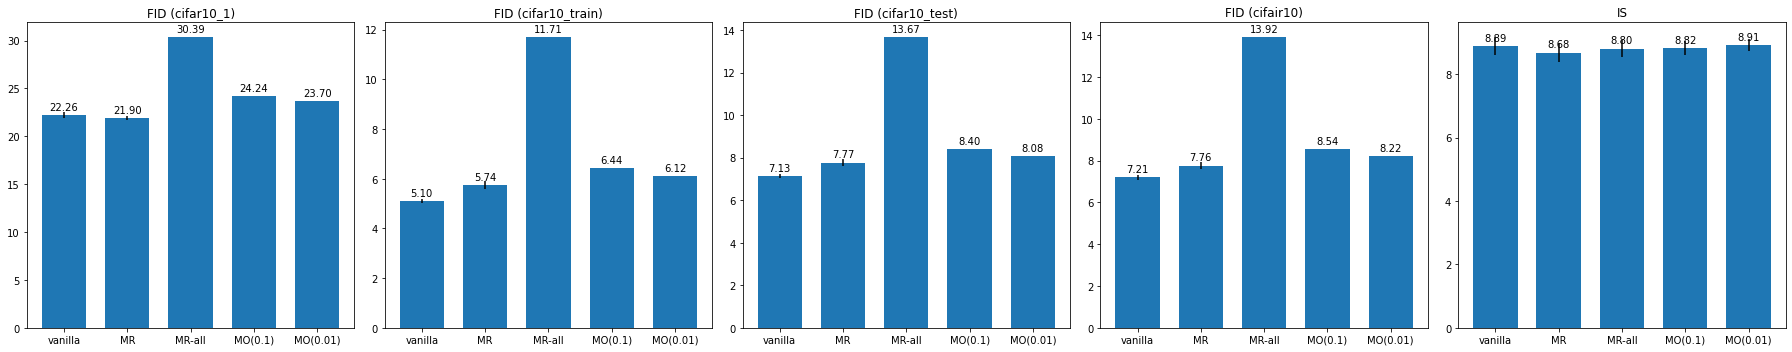

In [28]:
fids, IS_means, IS_stds = calculate_inception_metrics(samplers)

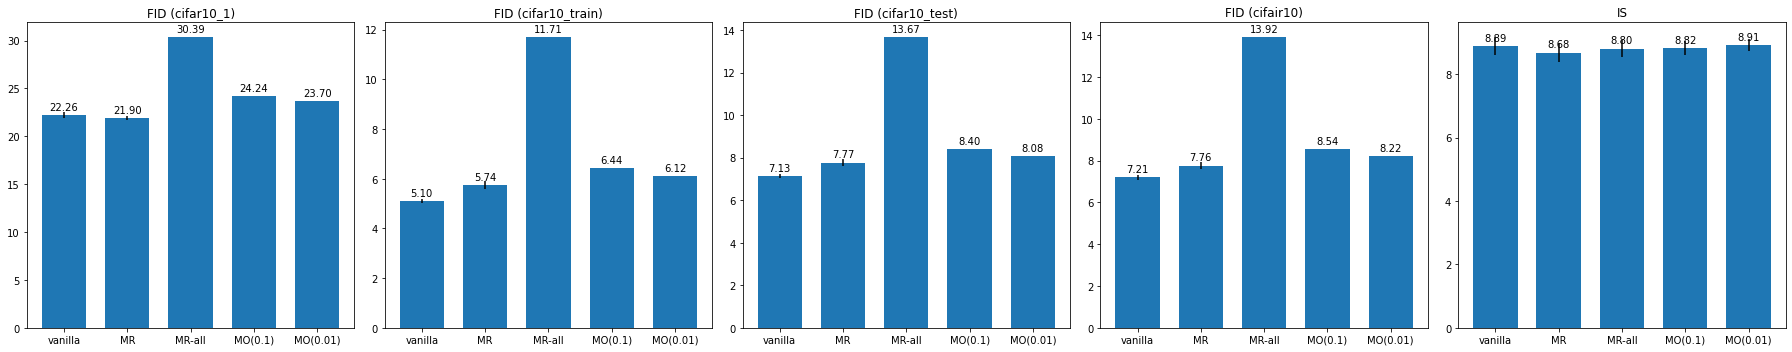

In [29]:
plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname='custom_inception_metrics(cifar10_special).pdf')

In [30]:
def calculate_C_T(runs, dls, proj_model, train_dset_name='cifar10_train'):
    feats = {}
    labels = {}
    for dset_name, dl in dls.items():
        (xs_, ys_), feats_, logits_ = misc.project(dl, proj_model, n_samples=None, to_numpy=True)
        # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
        feats[dset_name] = feats_
        labels[dset_name] = ys_
        
    class_stats = {}
    for n_class in range(10):
        print(f"n_class = {n_class}")
        train_pool = feats[train_dset_name][labels[train_dset_name] == n_class]
        
        pca_xf = PCA(n_components=64).fit(train_pool)
        train_pca = pca_xf.transform(train_pool)
        
        class_gen_feats = {}
        for mrt, runs_ in runs.items():
            class_gen_feats_ = []
            for run in runs_:
                sampler = misc.wrapper_best(run, 'CIFAR10', device=device, sample_mode=n_class)
                _, feats_, _ = misc.project(sampler, proj_model, n_samples=10000, 
                                            to_numpy=True, return_logits=False)
                class_gen_feats_.append(feats_)
                del _
            class_gen_feats[mrt] = class_gen_feats_
                
        stats = {}
        for dset_name in feats.keys():

            if dset_name == train_dset_name:
                continue

            n_clusters = min(feats[dset_name].shape[0], train_pool.shape[0]) // 200
            km_clf = KMeans(n_clusters=n_clusters).fit(train_pca)
            T_labels = km_clf.predict(train_pca)

            test_pool = feats[dset_name][labels[dset_name] == n_class]
            
            test_pca = pca_xf.transform(test_pool)
            Pn_labels = km_clf.predict(test_pca)

            C_Ts = {}

            for mrt, class_gen_feats_ in class_gen_feats.items():
                for gen_pool in class_gen_feats_:
                    gen_pca = pca_xf.transform(gen_pool)
                    Qm_labels = km_clf.predict(gen_pca)
                    # Qm_labels = km_clf.predict(sampled_pool)

                    # C_T = data_copying_tests.C_T(test_pca, Pn_labels, gen_pca, Qm_labels, 
                    #                              train_pca, T_labels, tau=20 / len(gen_pca))
                    C_T = data_copying_tests.C_T(test_pool, Pn_labels, gen_pool, Qm_labels, 
                                                 train_pool, T_labels, tau=20 / len(gen_pool))
                    if mrt not in C_Ts:
                        C_Ts[mrt] = [C_T]
                    else:
                        C_Ts[mrt].append(C_T)
            stats_ = {mrt: {'C_T_mean': np.mean(C_Ts_), 'C_T_std': np.std(C_Ts_)}
                      for mrt, C_Ts_ in C_Ts.items()}

            stats[dset_name] = stats_

        class_stats[n_class] = stats
    return class_stats

def plot_C_T(class_stats, savefig_fname=None):
    ordered_dsets = ['cifar10_1', 'cifair10', 'cifar10_test']
    n_dset = len(ordered_dsets)
    width = 0.7 / n_dset  # the width of the bars
    x_shifts = np.arange(n_dset) * width - (n_dset - 1) * width / 2

    fig, axs = plt.subplots(2, 5, figsize=(25, 10))
    
    max_val = 0
    for ax, (n_class, stats) in zip(axs.flat, class_stats.items()):

        for x_shift, dset_name in zip(x_shifts, ordered_dsets):
            stats_ = stats[dset_name]
            y = [v['C_T_mean'] for mrt, v in stats_.items()]
            max_val = max(max_val, np.abs(y).max())
            x = np.arange(len(y))
            rects = ax.bar(x + x_shift, y, width,
                           yerr=[v['C_T_std'] for mrt, v in stats_.items()], label=dset_name)

            misc.autolabel(rects, ax)
            ax.set_xticks(x)
            ax.set_xticklabels([mrt for mrt in stats_.keys()])
            ax.set_title(f"C_T (class = {cifar10_classnames[n_class]})")
    
    for ax in axs.flat:
        # ax.set_xlabel(r'$\tau$')
        ax.set_ylim(-np.ceil(max_val), np.ceil(max_val))
        ax.legend(loc='lower right')
        ax.grid(axis='y')

    plt.tight_layout()
    if savefig_fname is not None:
        plt.savefig(savefig_fname, bbox_inches='tight')

In [31]:
class_stats = calculate_C_T(special_runs, ref_dls, proj_model)

n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 5
n_class = 7
n_class = 8
n_class = 9


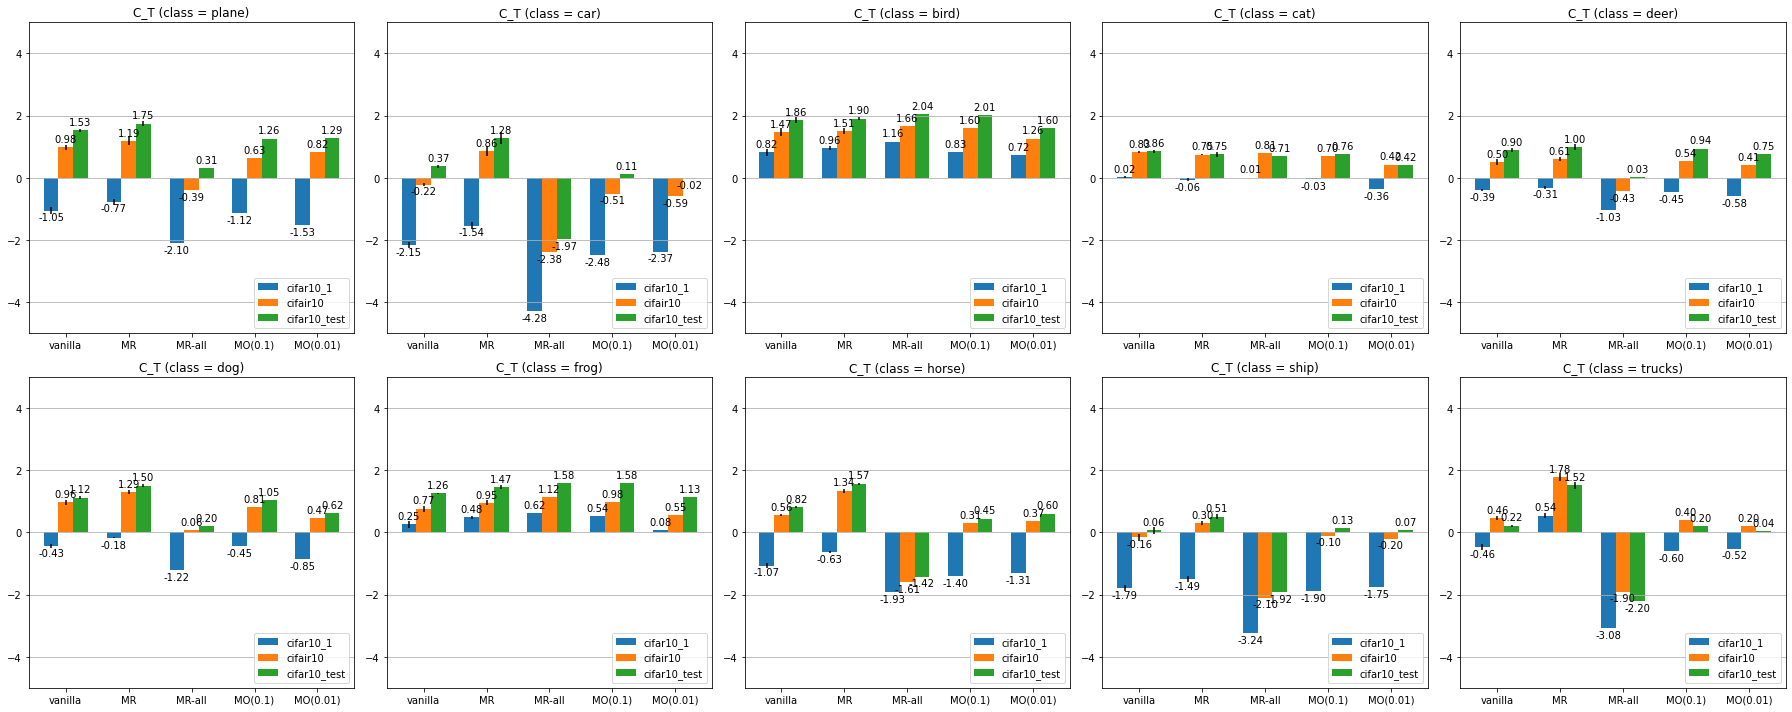

In [32]:
plot_C_T(class_stats, savefig_fname='data_copying_metrics(cifar10_special).pdf')